# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [1]:
import numpy as np
import random
import torch
import os
import torch.nn as nn
import torch.optim as optim
import shutil
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
import setcwd
setcwd.main()

import importlib

import gagf.models as models
import gagf.datasets as datasets
import gagf.theory as theory
import gagf.train as train
import gagf.viz as viz


Git root path:  /home/adele/code/group-agf

Working directory:  /home/adele/code/group-agf/gagf
Directory added to path:  /home/adele/code/group-agf
Directory added to path:  /home/adele/code/group-agf/gagf/notebooks


# Define Dataset and Visualize

Template mean: -3.469446951953614e-18


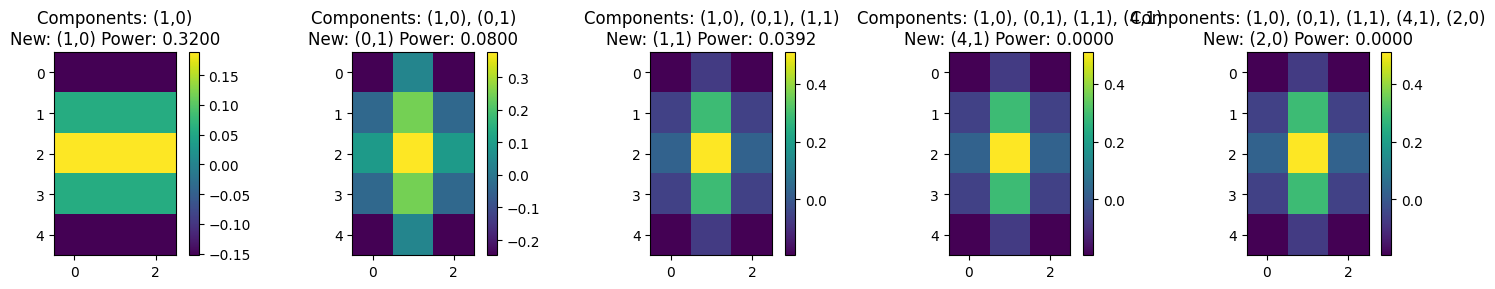

Translation for sample 4: a=(1, 3), b=(4, 1), a+b=(0, 4)


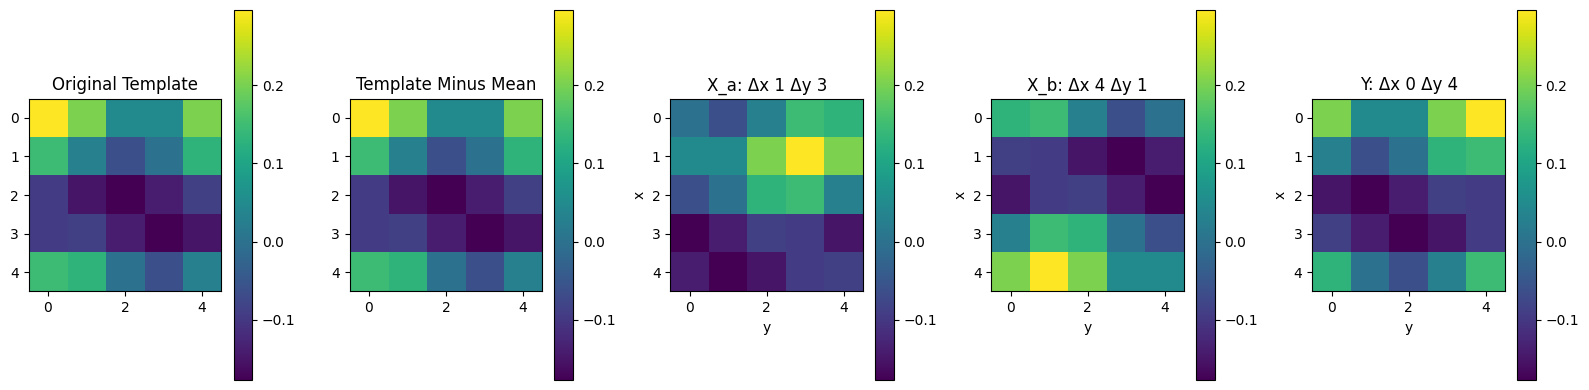

X_tensor shape: torch.Size([625, 50]), Y_tensor shape: torch.Size([625, 25])
GPU is available. Using CUDA.


In [2]:
# Data Generation using the new function
p = 5  # Modulus

# Choose template
# template = generate_template(p, 2, 1.0)
# template = one_hot2D(p)
# og_template = datasets.mnist_template(p)
og_template = datasets.generate_fixed_template(p)

print("Template mean:", np.mean(og_template))

# Mean center template
template = og_template - np.mean(og_template) # subtract the zeroth frequency

viz.plot_top_template_components(template, p)

# Generate dataset using numpy
X, Y, indices = datasets.ModularAdditionDataset2D(p, template, fraction=1.0)
viz.plot_template(X, Y, og_template, template, indices, p, i=4)

# Convert to PyTorch tensors
X_len = X.shape[-1]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * X_len)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)
print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# Move tensors and model to the correct device if not already
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

## Gradient Descent Experiment

In [ ]:
seed = 10 #0  # or any integer you like
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Initialize model
hidden_size = 6 * p * p  # 6 * size of group
init_scale = 1e-2 # 1e-2
model = models.TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=init_scale, output_scale=1e0)
model = model.to(device)

# Check if tensors and model are on the correct device (cuda or cpu)
print(f"X_tensor device: {X_tensor.device}")
print(f"Y_tensor device: {Y_tensor.device}")
print(f"Model device: {next(model.parameters()).device}")

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
lr, mom = 0.001, 0.9 # originaly 0.01 and 0.9
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom) # TODO: try adam optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(mom, 0.999))

# Train the model
epochs = 10000#01
verbose_interval = 100
git_root_path = setcwd.get_root_dir()
fig_save_dir = os.path.join(git_root_path, "notebooks", "figs_temp")
print(f"Saving figures to {fig_save_dir}")

# Clear the figs_temp directory before training
if os.path.exists(fig_save_dir):
    shutil.rmtree(fig_save_dir)
os.makedirs(fig_save_dir, exist_ok=True)

neurons_to_plot = list(range(16))
print(f"Neurons to plot: {neurons_to_plot}")

loss_history, accuracy_history, param_history = train.train(model, dataloader, loss, optimizer, fig_save_dir, epochs=epochs, verbose_interval=verbose_interval, neurons_to_plot=neurons_to_plot)

X_tensor device: cuda:0
Y_tensor device: cuda:0
Model device: cuda:0
Saving figures to /home/adele/code/group-agf/notebooks/figs_temp
Neurons to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Epoch 100/10000, Loss: 0.0044, Accuracy: 44.96%
Epoch 100/10000, Loss: 0.004384
Epoch 200/10000, Loss: 0.0035, Accuracy: 60.00%
Epoch 200/10000, Loss: 0.003487
Epoch 300/10000, Loss: 0.0032, Accuracy: 56.00%
Epoch 300/10000, Loss: 0.003163
Epoch 400/10000, Loss: 0.0031, Accuracy: 48.00%
Epoch 400/10000, Loss: 0.003145
Epoch 500/10000, Loss: 0.0031, Accuracy: 48.64%
Epoch 500/10000, Loss: 0.003142
Epoch 600/10000, Loss: 0.0027, Accuracy: 75.52%
Epoch 600/10000, Loss: 0.002679
Epoch 700/10000, Loss: 0.0021, Accuracy: 84.00%
Epoch 700/10000, Loss: 0.002122
Epoch 800/10000, Loss: 0.0016, Accuracy: 100.00%
Epoch 800/10000, Loss: 0.001628
Epoch 900/10000, Loss: 0.0016, Accuracy: 100.00%
Epoch 900/10000, Loss: 0.001575
Epoch 1000/10000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1000/10000, Loss

In [ ]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump({
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "param_history": param_history
    }, f)

print("Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).")



Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).


## Plot Loss

p: 5
[[1.97215226e-33 8.00000000e-02 4.71852836e-35]
 [3.20000000e-01 3.92000000e-02 5.44653768e-36]
 [2.21867130e-33 8.66668475e-34 7.06577882e-34]
 [0.00000000e+00 1.88741135e-34 1.62266194e-34]
 [0.00000000e+00 3.94430453e-33 4.02600939e-34]]
[ 0.   0.2  0.4 -0.4 -0.2]
[0.  0.2 0.4]


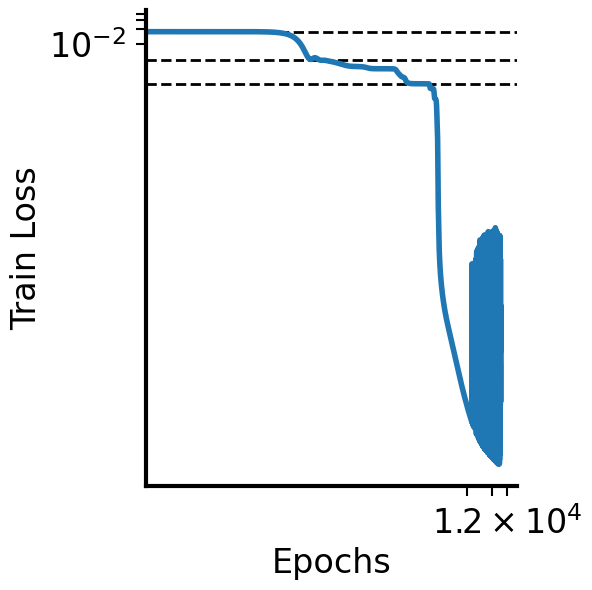

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)


# === Compute power spectrum of template ===
p = int(np.sqrt(len(template)))
print("p:", p)
x_freq, y_freq, power = theory.get_power_2d(template.reshape((p, p)))
print(power)
print(x_freq)
print(y_freq)
power = power.flatten()

valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
power = power[sorted_idx]

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p * p)

# alpha_values = get_alpha_values(template)

for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef*alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-2, 1e0)

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

viz.style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

p = 5
freq shape: (15, 2)
power shape: (5, 3)
Template power shape: (15,)
[[1.97215226e-33 8.00000000e-02 4.71852836e-35]
 [3.20000000e-01 3.92000000e-02 5.44653768e-36]
 [2.21867130e-33 8.66668475e-34 7.06577882e-34]
 [0.00000000e+00 1.88741135e-34 1.62266194e-34]
 [0.00000000e+00 3.94430453e-33 4.02600939e-34]]
Flattened_template_power [1.97215226e-33 8.00000000e-02 4.71852836e-35 3.20000000e-01
 3.92000000e-02 5.44653768e-36 2.21867130e-33 8.66668475e-34
 7.06577882e-34 0.00000000e+00 1.88741135e-34 1.62266194e-34
 0.00000000e+00 3.94430453e-33 4.02600939e-34]
Valid indices: [False  True False  True  True False False False False False False False
 False False False]
Sorted indices: [1 0 2]
15
Powers over time shape: (599, 15)


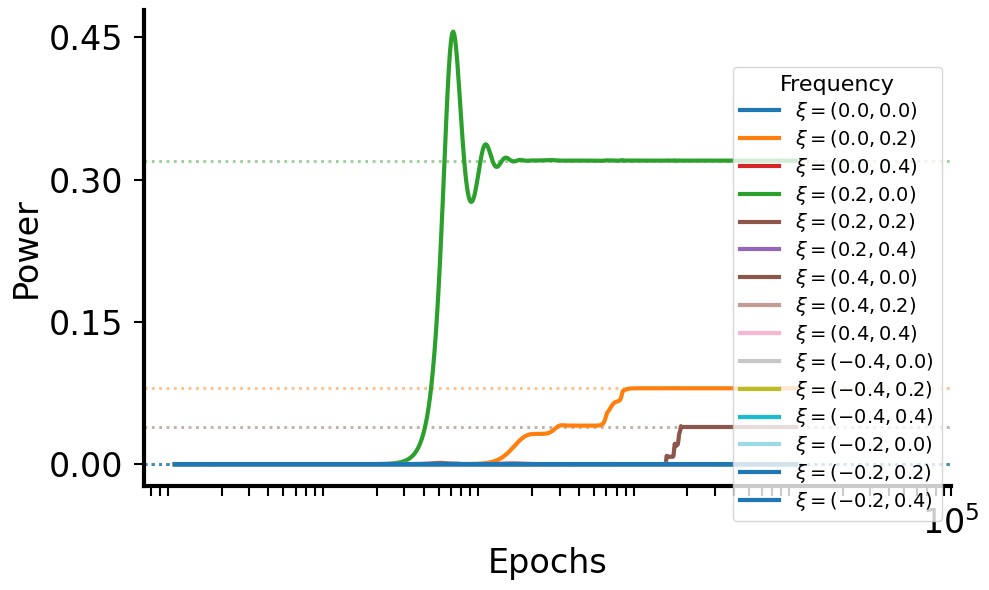

In [ ]:
importlib.reload(theory)

# === SETTINGS ===
print("p =", p)
pxp = p * p
num_freqs = pxp // 2 + 1

# Compute template power spectrum (flattened 2D)
template_2d = template.reshape((p, p))
template_ft_2d = np.fft.rfft2(template_2d)
# template_power_2d = np.abs(template_ft_2d).flatten()[:num_freqs]

# === Compute power spectrum of template ===
freqs_u, freqs_v, template_power = theory.get_power_2d(template_2d)
freq = np.array([(u, v) for u in freqs_u for v in freqs_v])
print("freq shape:", freq.shape)
print("power shape:", template_power.shape)
# freq_flattened = freq.flatten()
# print("freq_flattened shape:", freq_flattened.shape)
flattened_template_power = template_power.flatten()
print("Template power shape:", flattened_template_power.shape)

alpha_values, flattened_filtered_template_power, valid_flattened_power_indices, sorted_valid_idx = theory.get_alpha_values_and_valid_freq(template)
print("Flattened_template_power", flattened_template_power)
print("Valid indices:", valid_flattened_power_indices)
print("Sorted indices:", sorted_idx)

# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

print(len(template_power.flatten()))
model_inputs = X_tensor
model_powers_over_time, steps = theory.model_power_over_time(model, param_history, model_inputs, len(template_power.flatten()), p) # models_powers_over_time shape: (num_steps, num_freqs), includes all frequencies in rfft

# Create a new figure for this plot
plt.figure(figsize=(10, 6))

for i in range(len(freq)):
    color = colors[i] if i < len(colors) else colors[0]
    label = fr"$\xi = ({freq[i][0]}, {freq[i][1]})$"
    plt.plot(steps, model_powers_over_time[:, i], color=color, lw=3, label=label)
    plt.axhline(flattened_template_power[i], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

# Labeling and formatting
plt.xscale('log')
plt.xlim(0, len(param_history) - 1)
plt.xticks([1000, 10000, 100000, len(param_history) - 1], ['$10^3$', '$10^4$', '$10^5$', 'Final'])
plt.ylabel("Power", fontsize=24)
plt.xlabel("Epochs", fontsize=24)
plt.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

# Use the current axes for styling
ax = plt.gca()
viz.style_axes(ax)
ax.grid(False)
plt.tight_layout()
# plt.savefig("fourier_power_only.png", bbox_inches="tight")
plt.show()

## Plot outputs

## Plot Weights